# Brain decoding with MLP

We are going to train a `Multilayer Perceptron` (`MLP`) `classifier` for `brain decoding` on the [Haxby dataset](https://main-educational.github.io/brain_encoding_decoding/haxby_data.html). `MLP`s are one of the most basic architecture of [artificial neural networks](https://en.wikipedia.org/wiki/Artificial_neural_network). As such, `MLP`s consist of `input` and `output` `layers` as well as `hidden layers` that process the `input` through a succession of `transformations` towards the `output layer` that performs the task at hand, e.g. a `classification` or `regression`. Like other `machine learning models` for `supervised learning`, an `MLP` initially goes through a `training phase`. During this `supervised phase`, the `network` is taught what to look for and what is the desired output via its `objective function`. This refers to, minimizing the `loss`, ie the deviation of `predictions` from the "ground truth", and thus increasing its performance.

## Theoretical motivation

The previous tutorial on [brain decoding with SVM](https://main-educational.github.io/brain_encoding_decoding/svm_decoding.html)
shows how to use a linear combination of brain features to train a predictor.

Let's take a moment to consider this: a 1-layer perceptron with a sigmoid activation function
models the relation between `X` (the input data) and `y` (the predicted data)
the same way a logistic regression would:
$\hat{y} = \sigma(X \beta + \beta_0)$

If one optimizes the parameters of this MLP to minimize a cross-entropy loss,
they're actually optimizing for the same objective function as in a classical logistic regression problem:
$\underset{\beta, \beta_0}{\min} \sum_k y_k \log(\hat{y_k}) + (1 - y_k) \log(1 - \hat{y_k})$

As a rule of thumb, one can consider that a 1-layer perceptron
(and therefore any last layer of a multi-layer perceptron)
works similarly to an SVC.

A big motivation for using multiple-layer perceptrons is that they can introduce non-linearities
in our data. When training such models, the hope is that the hidden layers of the model
will find meaningful non-linear combinations of the input features which help us solve
our decoding problem.

## Getting the data

We are going to work with the Haxby dataset {cite:p}`Haxby2001-vt` again. You can check the section {ref}`haxby-dataset` for more details on that `dataset`. Here we are going to quickly `download` and prepare it for `machine learning applications` with a set of `predictive variables`, the `brain time series` `X`, and a `dependent variable`, the respective `cognitive processes`/`function`/`percepts` `y`.

In [1]:
import os
import warnings
warnings.filterwarnings(action='once')

from nilearn import datasets
# We are fetching the data for subject 4
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

# mask the data
from nilearn.input_data import NiftiMasker
mask_filename = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_filename, standardize=True, detrend=True)
X = masker.fit_transform(func_file)

# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
y = behavioral['labels']

/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, DeprecationWarning)
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/joblib/memory.py:312: DeprecationWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option w

As an initial check, we'll have a look at the size of `X` and `y`:

In [2]:
categories = y.unique()
print(categories)
print(y.shape)
print(X.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)
(1452, 675)


So we have `1452` `time points`, with one `label` for the respective `stimulus percept` each, and for each `time point` we have `recordings` of `brain` activity obtained via  `fMRI` across `675 voxels` (within the `VT` `mask`). We can also see that the `stimulus percept`s span `9` different `categories`.

However, concerning our planned analyses, we need to convert our `categories` into a [one-hot encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [3]:
y

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object

In [4]:
# creating instance of one-hot-encoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
enc = OneHotEncoder(handle_unknown='ignore')
y_onehot = enc.fit_transform(np.array(y).reshape(-1, 1))
print(y_onehot)

  (0, 5)	1.0
  (1, 5)	1.0
  (2, 5)	1.0
  (3, 5)	1.0
  (4, 5)	1.0
  (5, 5)	1.0
  (6, 3)	1.0
  (7, 3)	1.0
  (8, 3)	1.0
  (9, 3)	1.0
  (10, 3)	1.0
  (11, 3)	1.0
  (12, 3)	1.0
  (13, 3)	1.0
  (14, 3)	1.0
  (15, 5)	1.0
  (16, 5)	1.0
  (17, 5)	1.0
  (18, 5)	1.0
  (19, 5)	1.0
  (20, 5)	1.0
  (21, 2)	1.0
  (22, 2)	1.0
  (23, 2)	1.0
  (24, 2)	1.0
  :	:
  (1427, 0)	1.0
  (1428, 0)	1.0
  (1429, 0)	1.0
  (1430, 0)	1.0
  (1431, 0)	1.0
  (1432, 5)	1.0
  (1433, 5)	1.0
  (1434, 5)	1.0
  (1435, 5)	1.0
  (1436, 5)	1.0
  (1437, 6)	1.0
  (1438, 6)	1.0
  (1439, 6)	1.0
  (1440, 6)	1.0
  (1441, 6)	1.0
  (1442, 6)	1.0
  (1443, 6)	1.0
  (1444, 6)	1.0
  (1445, 6)	1.0
  (1446, 5)	1.0
  (1447, 5)	1.0
  (1448, 5)	1.0
  (1449, 5)	1.0
  (1450, 5)	1.0
  (1451, 5)	1.0


In [5]:
np.array(y).reshape(-1, 1)

array([['rest'],
       ['rest'],
       ['rest'],
       ...,
       ['rest'],
       ['rest'],
       ['rest']], dtype=object)

In [6]:
y_onehot.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
# turn the sparse matrix into a pandas dataframe
y = pd.DataFrame(y_onehot.toarray())
display(y[:100])

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
95,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training a model

As introduced in the prior `tutorials`, one of the most important aspects of `machine learning` is the split between `train` and `tests`. `MLP`s are no exception to that and thus we need to split our dataset accordingly. We will keep `20%` of the `time points` as `test`, and then set up a `10 fold cross validation` for `training/validation`.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)   

With that, we can already build our `MLP`. Here, we are going to use [Tensorflow](https://www.tensorflow.org/) and [Keras](https://keras.io/). As with every other `ANN`, we need to `import` the respective components, here, the `model` and `layer` `type`. In our case we will use a [`Sequential` `model`](https://keras.io/guides/sequential_model/) and [`Dense`](https://keras.io/api/layers/core_layers/dense/) `layers`.

In [9]:
from keras.models import Sequential
from keras.layers import Dense

Initially, we need to create our, so far, `empty model`.

In [10]:
# number of unique conditions that we have
model_mlp = Sequential()

model_mlp.add(Dense(50, input_dim = 675, kernel_initializer="uniform", activation = 'relu'))
model_mlp.add(Dense(30, kernel_initializer="uniform", activation = 'relu'))
model_mlp.add(Dense(len(categories), activation = 'softmax'))

model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                33800     
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dense_2 (Dense)             (None, 9)                 279       
                                                                 
Total params: 35,609
Trainable params: 35,609
Non-trainable params: 0
_________________________________________________________________


Set the optimizer, loss function and metric

In [11]:
model_mlp.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
history = model_mlp.fit(X_train, y_train, batch_size = 10,
                        epochs = 10, validation_split = 0.2)

Epoch 1/10
 1/93 [..............................] - ETA: 13s - loss: 2.1534 - accuracy: 0.4000

2024-05-30 12:40:36.401880: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


93/93 [==============================] - 0s 1ms/step - loss: 1.5961 - accuracy: 0.4612 - val_loss: 1.4578 - val_accuracy: 0.4893
Epoch 2/10
93/93 [==============================] - 0s 804us/step - loss: 1.1254 - accuracy: 0.6099 - val_loss: 1.1401 - val_accuracy: 0.6395
Epoch 3/10
93/93 [==============================] - 0s 802us/step - loss: 0.8028 - accuracy: 0.7468 - val_loss: 0.9855 - val_accuracy: 0.6481
Epoch 4/10
93/93 [==============================] - 0s 816us/step - loss: 0.5456 - accuracy: 0.8384 - val_loss: 1.0014 - val_accuracy: 0.6781
Epoch 5/10
93/93 [==============================] - 0s 789us/step - loss: 0.3651 - accuracy: 0.8998 - val_loss: 0.8168 - val_accuracy: 0.7124
Epoch 6/10
93/93 [==============================] - 0s 790us/step - loss: 0.2223 - accuracy: 0.9494 - val_loss: 0.7977 - val_accuracy: 0.7511
Epoch 7/10
93/93 [==============================] - 0s 799us/step - loss: 0.1409 - accuracy: 0.9666 - val_loss: 0.7682 - val_accuracy: 0.7768
Epoch 8/10
93/93 [=

Plot the loss and accuracy in the training and validation sets respectively

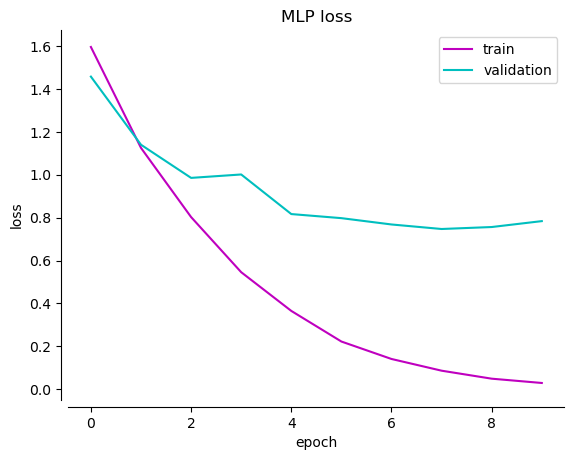

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'], color='m')
plt.plot(history.history['val_loss'], color='c')
plt.title('MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')

sns.despine(offset=5)

plt.show()

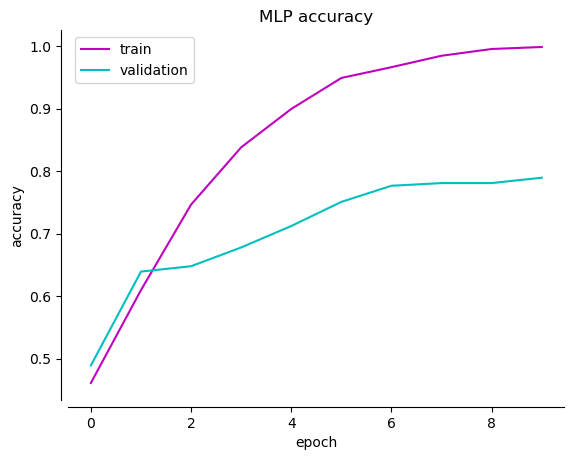

In [14]:
plt.plot(history.history['accuracy'], color='m')
plt.plot(history.history['val_accuracy'], color='c')
plt.title('MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')

sns.despine(offset=5)

plt.show()

## Assessing performance

- Performance on the training set

In [15]:
from sklearn.metrics import classification_report
y_train_pred = model_mlp.predict(X_train)
print(classification_report(y_train.values.argmax(axis = 1), y_train_pred.argmax(axis=1)))

37/37 [==============================] - 0s 401us/step
              precision    recall  f1-score   support

           0       0.89      0.93      0.91        85
           1       0.96      0.98      0.97        88
           2       0.98      0.90      0.94        90
           3       0.99      0.96      0.97        81
           4       0.99      0.98      0.98        91
           5       0.98      0.98      0.98       471
           6       0.86      0.93      0.89        81
           7       0.96      0.98      0.97        90
           8       0.93      0.89      0.91        84

    accuracy                           0.96      1161
   macro avg       0.95      0.95      0.95      1161
weighted avg       0.96      0.96      0.96      1161



In [25]:
y_train_pred[:2,:]

array([[8.5193598e-08, 1.8249166e-10, 7.2197309e-08, 1.1606604e-10,
        1.8152182e-09, 9.9999976e-01, 1.1157946e-09, 3.4827139e-08,
        1.2038857e-11],
       [9.8821855e-01, 3.6432238e-03, 1.8990567e-03, 1.5142058e-04,
        9.8349210e-07, 4.8363887e-05, 2.8806890e-03, 5.8832416e-06,
        3.1518245e-03]], dtype=float32)

In [26]:
y_train_pred[:2,:].argmax(axis=1)

array([5, 0])

- Performance on the testing set

In [27]:
y_test_pred = model_mlp.predict(X_test)
print(classification_report(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1)))

10/10 [==============================] - 0s 667us/step
              precision    recall  f1-score   support

           0       0.67      0.78      0.72        23
           1       0.63      0.85      0.72        20
           2       0.71      0.56      0.63        18
           3       0.92      0.85      0.88        27
           4       0.94      0.88      0.91        17
           5       0.90      0.91      0.91       117
           6       0.79      0.56      0.65        27
           7       0.85      0.94      0.89        18
           8       0.54      0.54      0.54        24

    accuracy                           0.81       291
   macro avg       0.77      0.76      0.76       291
weighted avg       0.81      0.81      0.81       291



In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1))
model_conf_matrix = cm_svm.astype('float') / cm_svm.sum(axis = 1)[:, np.newaxis]

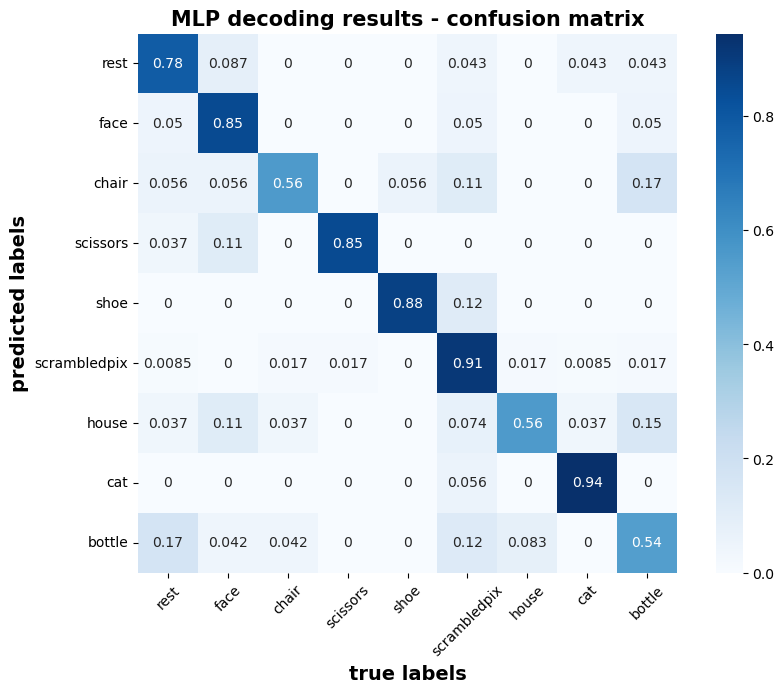

In [29]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(model_conf_matrix, index = categories,
                     columns = categories)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot = True, cmap = 'Blues', square = True)
plt.xticks(rotation = 45)
plt.title('MLP decoding results - confusion matrix' , fontsize = 15, fontweight = 'bold')
plt.xlabel("true labels", fontsize = 14, fontweight = 'bold')
plt.ylabel("predicted labels", fontsize = 14, fontweight = 'bold')
plt.show()

# Exercises
- What is the most difficult category to decode? Why?

**Response:**<br>
The bottle is the most difficult category to decode becuase it has the lowest accuracy throughout all categories.

- The model seemed to overfit. Try adding a Dropout layer to regularize the model. You can read about dropout in keras in this blog post.

In [42]:
from keras.layers import Dropout

model_mlp = Sequential()

model_mlp.add(Dense(50, input_dim=675, kernel_initializer="uniform", activation='relu'))
model_mlp.add(Dropout(0.2))  # Add Dropout layer with 20% dropout rate
model_mlp.add(Dense(30, kernel_initializer="uniform", activation='relu'))
model_mlp.add(Dropout(0.2))  # Add Dropout layer with 20% dropout rate
model_mlp.add(Dense(len(categories), activation='softmax'))

model_mlp.summary()
model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_mlp.fit(X_train, y_train, batch_size=10, epochs=16, validation_split=0.2, verbose=0)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 50)                33800     
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_19 (Dense)            (None, 30)                1530      
                                                                 
 dropout_11 (Dropout)        (None, 30)                0         
                                                                 
 dense_20 (Dense)            (None, 9)                 279       
                                                                 
Total params: 35,609
Trainable params: 35,609
Non-trainable params: 0
_________________________________________________________________


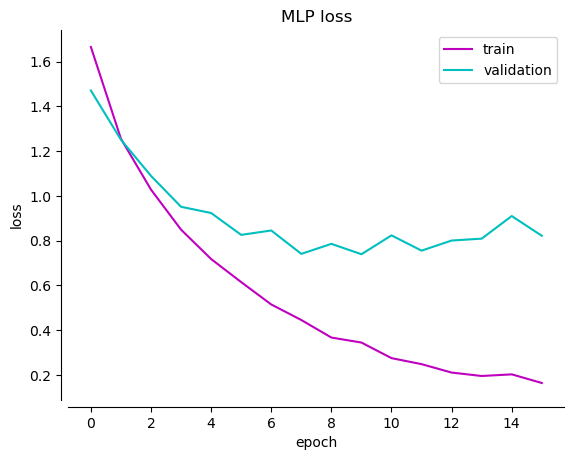

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'], color='m')
plt.plot(history.history['val_loss'], color='c')
plt.title('MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')

sns.despine(offset=5)

plt.show()

In [44]:
y_test_pred = model_mlp.predict(X_test)
print(classification_report(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1)))

10/10 [==============================] - 0s 500us/step
              precision    recall  f1-score   support

           0       0.75      0.78      0.77        23
           1       0.77      0.85      0.81        20
           2       0.73      0.61      0.67        18
           3       0.93      1.00      0.96        27
           4       0.88      0.88      0.88        17
           5       0.93      0.89      0.91       117
           6       0.68      0.78      0.72        27
           7       0.85      0.94      0.89        18
           8       0.76      0.67      0.71        24

    accuracy                           0.85       291
   macro avg       0.81      0.82      0.81       291
weighted avg       0.85      0.85      0.84       291



Try to add layers or hidden units, and observe the impact on overfitting and training time.

In [60]:
model_mlp = Sequential()

model_mlp.add(Dense(100, input_dim=675, kernel_initializer="uniform", activation='relu'))  # Increased units to 100
model_mlp.add(Dense(50, kernel_initializer="uniform", activation='relu'))
model_mlp.add(Dense(30, kernel_initializer="uniform", activation='relu'))
model_mlp.add(Dense(len(categories), activation='softmax'))

model_mlp.summary()
model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_mlp.fit(X_train, y_train, batch_size=10, epochs=10, validation_split=0.2, verbose=0)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 100)               67600     
                                                                 
 dense_42 (Dense)            (None, 50)                5050      
                                                                 
 dense_43 (Dense)            (None, 30)                1530      
                                                                 
 dense_44 (Dense)            (None, 9)                 279       
                                                                 
Total params: 74,459
Trainable params: 74,459
Non-trainable params: 0
_________________________________________________________________


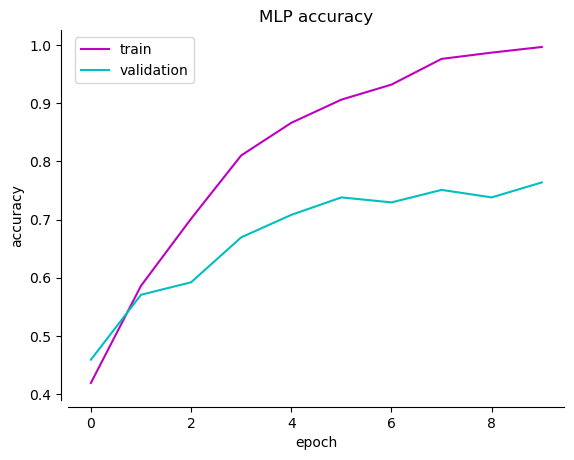

In [61]:
plt.plot(history.history['accuracy'], color='m')
plt.plot(history.history['val_accuracy'], color='c')
plt.title('MLP accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')

sns.despine(offset=5)

plt.show()

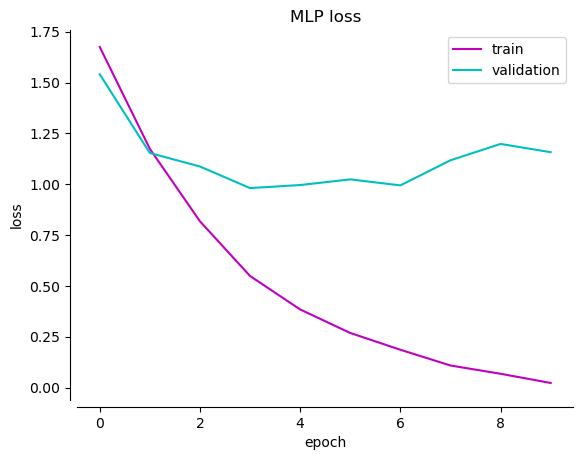

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'], color='m')
plt.plot(history.history['val_loss'], color='c')
plt.title('MLP loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')

sns.despine(offset=5)

plt.show()

In [59]:
y_test_pred = model_mlp.predict(X_test)
print(classification_report(y_test.values.argmax(axis = 1), y_test_pred.argmax(axis=1)))

10/10 [==============================] - 0s 512us/step
              precision    recall  f1-score   support

           0       0.62      0.87      0.73        23
           1       0.75      0.60      0.67        20
           2       0.50      0.61      0.55        18
           3       0.96      1.00      0.98        27
           4       1.00      0.82      0.90        17
           5       0.91      0.88      0.90       117
           6       0.69      0.67      0.68        27
           7       0.84      0.89      0.86        18
           8       0.76      0.67      0.71        24

    accuracy                           0.81       291
   macro avg       0.78      0.78      0.78       291
weighted avg       0.83      0.81      0.82       291

